# $k$-bandits manchots

*Version 1 - Elise Chin, December 2021*

1. [$\epsilon$-greedy Policy](#sec1)
2. [Optimistic Initialization](#sec2)
3. [Upper-Bound-Confidence (UCB) Action Selection](#sec3)
4. [Gradient Bandit](#sec4)

Supposons que nous ayons 10 machines à sous devant nous et 1000 jetons à notre disposition pour jouer aux machines. Chaque machine à sous a une récompense moyenne inconnue. On souhaite maximiser notre gain total. C'est le problème des $k$-bandits manchots, où $k=10$.

Formellement :
- __Actions__ : $\mathcal{A} = \{0,1, ..., 9\}$, où l'action $a=0$ correspond à l'essai de la machine 0, $a=1$ l'essai de la machine 1, etc.
- __Etats__ :  Puisque les machines à sous ne sont pas modifiées entre chaque action, il y a seulement un seul état. Le problème est ainsi simplifié et l'agent peut uniquement se concentrer sur la récompense immédiate obtenue pour chaque action, et n'a pas besoin de prendre en compte l'effet de l'action sur l'état de l'environnement.
- __Récompense__ : on note $R_t$ la récompense obtenue lorsque le $t^{ième}$ jeton est utilisée pour jouer la machine $A_t$. 

Afin de formaliser l'objectif, on définit la valeur d'une action, $q_*(a)$, comme étant l'espérance des récompenses lorsque $a$ est choisie, i.e. $q_*(a) = \mathbb{E}[R_t | A_t = a]$. Ici, $q_*$ peut être représentée par un array de 10 élements, où chaque élement est la valeur de l'action correspondante.

Si on connaît la fonction de valeur $q_\ast(a)$, la politique optimale serait de toujours choisir l'action gloutonne :
$$
A = \underset{a}{\operatorname{argmax}} q_*(a).
$$


__Learn__

Cependant, on ne connaît pas $q_*(a)$. Une estimation possible de l'espérance des récompenses pour une action $a$ serait la moyenne des récompenses obtenues en jouant $a$ jusqu'à présent. Autrement dit, lorsque $n-1$ actions ont été réalisées, on peut calculer une estimation de $q_*(a)$ de la manière suivante :

$$
Q_n(a) = \frac{\text{Somme des récompenses obtenues en jouant $a$ avant $n$}}{\text{Nombre de fois où on a joué $a$ avant $n$}}
$$
où $Q_n(a) = 0$ si l'action $a$ n'a pas été choisie avant la $n^{ième}$ action. En particulier, $Q_1(a) = 0$ pour tout $a$.

Au lieu de calculer les sommes à chaque fois qu'une nouvelle action est choisie, on peut les mettre à jour progressivement. Plus précisement, si la $n^{ième}$ action est $A_n$ et la récompense obtenue est $R_n$, $Q_{n+1}(A_n)$ peut être calculée à partir de $Q_n(A_n)$ :

$$
Q_{n+1}(A_n) = Q_n(A_n) + \frac{1}{N(A_n)}(R_n - Q_n(A_n))
$$
où $N(A_n)$ est le nombre de fois où on a joué $A_n$ jusqu'à présent.

Si on initialise l'estimateur $Q_1(a) = 0 \space \forall a \in \mathcal{A}$, alors les deux expressions pour $Q_n(a)$ sont équivalentes. La deuxième expression est plus utile, car plus facile à implémenter. Ici, il suffit de créer un array de 10 éléments (un pour chaque action possible) et quelque soit l'action $a$ choisie, on observe une récompense et on met à jour l'élément $a$ dans l'array. Le pseudo-code est le suivant :

*Initialize:*

Pour tout $a \in \mathcal{A}$, 
  * $\quad Q(a) \leftarrow 0$
  * $\quad N(a) \leftarrow 0$
  
*Learn:*

Lorsque l'action $A$ est choisie avec une récompense $R$, mettre à jour l'estimation :
  * $N(A) \leftarrow N(A) + 1$
  * $Q(A) \leftarrow Q(A) + \frac{1}{N(A)} (R - Q(A))$

Commençons tout d'abord par importer les librairies nécessaires.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm # Progress bar

Le nombre de machines est représenté par la variable `n_machines`, le nombre de jetons par `n_tokens` et le nombre de runs par `n_runs`.

In [43]:
n_machines = 10
n_tokens = 1000
n_runs = 2000

On définit une fonction `simulation()` permettant de réaliser `n_runs` runs, avec `n_tokens` jetons possibles pour jouer avec les `n_machines` disponibles par run.

In [44]:
def simulation(agent_class, n_machines=10, n_tokens=1000, n_runs=2000, *args):
    
    rewards = np.zeros(n_tokens)
    cpt_actions = np.zeros(n_tokens)
    
    # For every run...
    for i_run in tqdm(range(n_runs)):
        
        # Initialize q_star 
        q_star = np.random.normal(loc=0., scale=1., size=n_machines) # q* is constant
        optimal_action = np.argmax(q_star)

        # Initialize the agent
        agent = agent_class()

        # For every token...
        for t in range(n_tokens):
            
            # Choose a machine
            action = agent.act()
            
            # Get the reward
            reward = np.random.normal(loc=q_star[action], scale=1.) 
            rewards[t] += reward
            
            # Update Q-value function
            agent.learn(action, reward)
            
            # Increment the counter if the action chosen is the optimal one
            if action == optimal_action:
                cpt_actions[t] += 1
                
    # Compute the frequency of choosing the optimal action            
    freq_optimal_actions = cpt_actions / n_runs
    
    # Compute the average rewards
    rewards_avg = rewards / n_runs

    return rewards, rewards_avg, freq_optimal_actions

## <a name="sec1">1. $\epsilon$-greedy Policy<a/>


__Act__

Etant donné une estimation $Q(a)$, comment choisir la prochaine action ?

Une réponse directe est de choisir celle qui maximise $Q(a)$. C'est ce qu'on appelle en RL le choix *glouton* (*greedy* en anglais), qui consiste à choisir l'action qui, selon les estimations actuelles, semble la meilleure.

Le problème de ce choix est que les estimations peuvent être incorrectes. Si l'estimation actuelle de la valeur de l'action optimale est trop faible, l'agent ne prendra pas cette action, et ne mettra donc jamais à jour la valeur estimée de celle-ci. En d'autres termes, l'agent n'explore pas toutes les possibilités. Une façon simple, mais souvent très efficace, d'ajouter de l'exploration est que l'agent choisisse l'action gloutonne la plupart du temps, mais avec une probabilité de $\varepsilon$, il choisit une action aléatoire.
C'est ce qu'on appelle une politique $\varepsilon$-glouton. De cette façon, l'agent continuera toujours à explorer différentes possibilités. Etant donné une estimation $Q(a)$, la politique $\varepsilon$-glouton peut s'écrire comme suit

$$
 \begin{cases} \underset{a}{\operatorname{argmax}} Q(a) & \text{with probability } 1-\varepsilon \\ \text{random action} & \text{with probability } \varepsilon\end{cases}
$$

In [8]:
class EpsAgent():
    def __init__(self, n_machines=10, epsilon=0):
        self.epsilon = epsilon
        self.n_machines = n_machines # Total number of machines
        self.N = np.zeros(n_machines) # Step count for each machine
        self.Q = np.zeros(n_machines) # Initialization of Q

    def learn(self, action, reward):
        self.N[action] += 1
        self.Q[action] = self.Q[action] + (reward - self.Q[action]) / self.N[action]
    
    def act(self):
        prob = np.random.random()
        if prob <= self.epsilon:
            action = np.random.choice(self.n_machines)
        else:
            action = np.argmax(self.Q)
        return action

In [ ]:
agent_0 = lambda: EpsAgent(epsilon=0)
rewards_0, rewards_0_avg, freq_optimal_actions_0 = simulation(agent_class=agent_0)

100%|██████████| 2000/2000 [00:32<00:00, 61.84it/s]


In [ ]:
agent_01 = lambda: EpsAgent(epsilon=0.1)
rewards_01, rewards_01_avg, freq_optimal_actions_01 = simulation(agent_class=agent_01)

100%|██████████| 2000/2000 [00:36<00:00, 54.71it/s]


In [ ]:
agent_001 = lambda: EpsAgent(epsilon=0.01)
rewards_001, rewards_001_avg, freq_optimal_actions_001 = simulation(agent_class=agent_001)

100%|██████████| 2000/2000 [00:31<00:00, 63.21it/s]


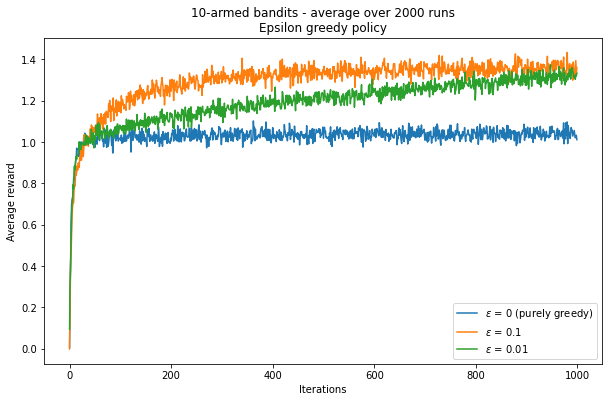

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_0_avg, label=r'$\epsilon$ = 0 (purely greedy)')
plt.plot(rewards_01_avg, label=r'$\epsilon$ = 0.1')
plt.plot(rewards_001_avg, label=r'$\epsilon$ = 0.01')
plt.title("10-armed bandits - average over 2000 runs\nEpsilon greedy policy")
plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.legend()

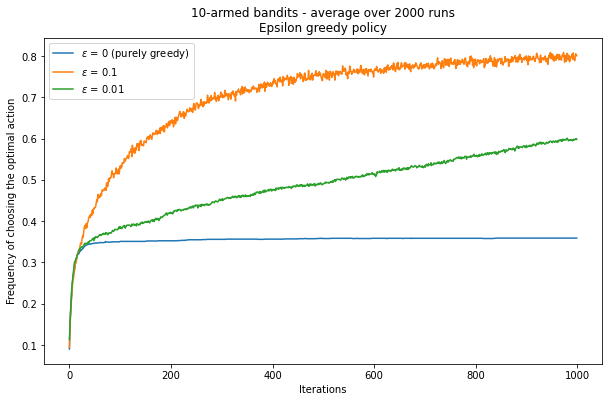

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(freq_optimal_actions_0, label=r'$\epsilon$ = 0 (purely greedy)')
plt.plot(freq_optimal_actions_01, label=r'$\epsilon$ = 0.1')
plt.plot(freq_optimal_actions_001, label=r'$\epsilon$ = 0.01')
plt.title("10-armed bandits - average over 2000 runs\nEpsilon greedy policy")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

__Peut-on choisir un meilleur ε que 0.1 pour $\epsilon$-greedy?__

In [9]:
epsilon_list = [0, 0.1, 0.2, 0.3, 0.5, 0.01, 0.001]
rewards_avg_list = []
freq_optimal_actions_list = []
for epsilon in epsilon_list:
    agent = lambda: EpsAgent(epsilon=epsilon)
    _, rewards_avg, freq_optimal_actions = simulation(agent_class=agent)
    rewards_avg_list.append(rewards_avg)
    freq_optimal_actions_list.append(freq_optimal_actions)

100%|██████████| 2000/2000 [00:27<00:00, 72.04it/s]


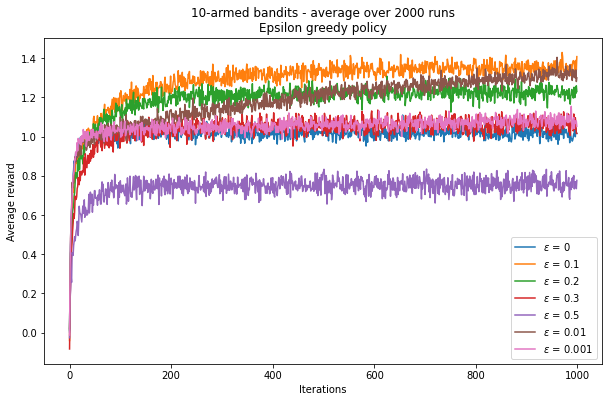

In [10]:
plt.figure(figsize=(10, 6))
for i, epsilon in enumerate(epsilon_list):
    plt.plot(rewards_avg_list[i], label=r'$\epsilon$ = {}'.format(epsilon))
plt.title("10-armed bandits - average over 2000 runs\nEpsilon greedy policy")
plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.legend()

Avec 1000 jetons, la politique 0.1-glouton semble être la meilleure (courbe orange). Cependant, 0.01-glouton (courbe marron) devrait atteindre un meilleur résultat si on avait plus de jetons. Vérifions cela.

In [13]:
epsilon_list = [0.1, 0.01]
rewards_avg_list = []
freq_optimal_actions_list = []
for epsilon in epsilon_list:
    agent = lambda: EpsAgent(epsilon=epsilon)
    _, rewards_avg, freq_optimal_actions = simulation(agent_class=agent, n_tokens=5000)
    rewards_avg_list.append(rewards_avg)
    freq_optimal_actions_list.append(freq_optimal_actions)

100%|██████████| 2000/2000 [02:14<00:00, 14.86it/s]


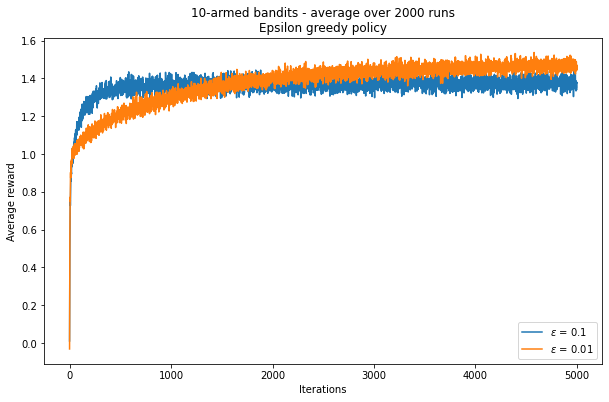

In [14]:
plt.figure(figsize=(10, 6))
for i, epsilon in enumerate(epsilon_list):
    plt.plot(rewards_avg_list[i], label=r'$\epsilon$ = {}'.format(epsilon))
plt.title("10-armed bandits - average over 2000 runs\nEpsilon greedy policy")
plt.xlabel("Iterations")
plt.ylabel("Average reward")
plt.legend()

La courbe orange est désormais au-dessus de la courbe bleue après environ 2000 jetons. En jouant plus longtemps, 0.01-glouton est effectivement une meilleure politique que 0.1-glouton.

## <a name="sec2">2. Optimistic Initialization<a/>

La valeur initiale des actions peut être un moyen d'encourager l'exploration. Au lieu d'initialiser notre estimateur à 0, comme précédemment, on pourrait initialiser les valeurs à +5. Puisque dans notre simulation $q_*$ suit une loi normale $\mathcal{N}(0,1)$, une initialisation des valeurs initiales à +5 sera très optimiste. Les récompenses obtenues après avoir joué une machine sera inférieure à ces valeurs initiales, encourageant ainsi l'agent à choisir d'autres actions, donc à explorer. Finalement, chacune des actions aura été choisie plusieurs fois avant que l'estimateur converge. 

In [19]:
class OptimisticAgent():
    def __init__(self, n_machines=10, epsilon=0, init=5):
        self.epsilon = epsilon
        self.n_machines = n_machines # Total number of machines
        self.N = np.zeros(n_machines) # Step count for each machine
        self.Q = init * np.ones(n_machines) # Initialization of Q
        self.alpha = 0.1

    def learn(self, action, reward):
        self.N[action] += 1
        self.Q[action] = self.Q[action] + self.alpha * (reward - self.Q[action])
    
    def act(self):
        prob = np.random.random()
        if prob <= self.epsilon:
            action = np.random.choice(self.n_machines)
        else:
            action = np.argmax(self.Q)
        return action

In [20]:
agent_init_5_eps_0 = lambda: OptimisticAgent(epsilon=0, init=5)
rewards_init_5_eps_0, rewards_init_5_eps_0_avg, freq_optimal_actions_init_5_eps_0 = simulation(agent_class=agent_init_5_eps_0)

100%|██████████| 2000/2000 [00:28<00:00, 70.18it/s]


In [23]:
agent_init_0_eps_01 = lambda: OptimisticAgent(epsilon=0.1, init=0)
rewards_init_0_eps_01, rewards_init_0_eps_01_avg, freq_optimal_actions_init_0_eps_01 = simulation(agent_class=agent_init_0_eps_01)

100%|██████████| 2000/2000 [00:27<00:00, 72.69it/s]


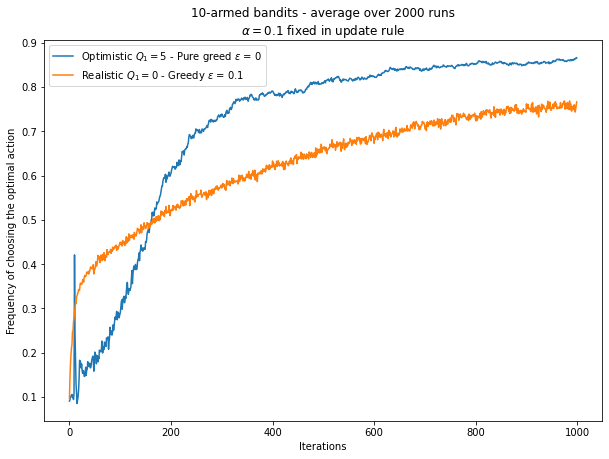

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(freq_optimal_actions_init_5_eps_0, label=r'Optimistic $Q_1=5$ - Pure greed $\epsilon$ = 0')
plt.plot(freq_optimal_actions_init_0_eps_01, label=r'Realistic $Q_1=0$ - Greedy $\epsilon$ = 0.1')
plt.title("10-armed bandits - average over 2000 runs\n" + r"$\alpha=0.1$ fixed in update rule")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

__Que se passe-t-il si l'initialisation n'est pas assez optimiste ou trop optimiste ?__

Une initialisation pas assez optimiste se rapprocherait d'une politique uniforme, où le choix des actions s'effectue de manière uniforme. Une initialisation trop optimiste rendra la méthode moins performante au début car elle explore plus, mais l'exploration diminuera avec le temps.

In [25]:
init_list = [-20, -5, 0, 5, 20]
rewards_avg_list = []
freq_optimal_actions_list = []
for init in init_list:
    agent = lambda: OptimisticAgent(epsilon=0.1, init=init)
    _, rewards_avg, freq_optimal_actions = simulation(agent_class=agent)
    rewards_avg_list.append(rewards_avg)
    freq_optimal_actions_list.append(freq_optimal_actions)

100%|██████████| 2000/2000 [00:27<00:00, 72.63it/s]


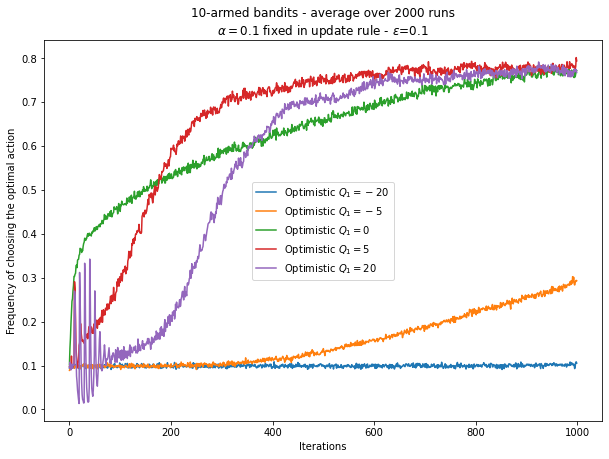

In [26]:
plt.figure(figsize=(10, 7))
for i, init in enumerate(init_list):
    plt.plot(freq_optimal_actions_list[i], label=r'Optimistic $Q_1={}$'.format(init))
plt.title("10-armed bandits - average over 2000 runs\n" + r"$\alpha=0.1$ fixed in update rule - $\epsilon$=0.1")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

Avec une initialisation très peu optimiste (-20 et -5), l'agent apprend très peu car il y a plus d'exploration que d'exploitation. La fréquence des bons choix avec une initialisation à -20 est de 0.1, ce qui correspond à la probabilité de choisir une action au hasard. Avec une initialisation très optimiste (5 et 20), on remarque que l'agent est moins performant au début due à l'exploration, puis devient plus performant puisque l'estimateur converge vers $q_*$ avec plus d'exploitation.

## <a name="sec3">3. Upper-Confidence-Bound (UCB) Action Selection<a/>

Avec une politique $\epsilon$-glouton, on traite les actions non gloutonnes de la même manière (tirage uniforme parmi les actions). Cependant, certaines actions sont plus prometteuses que les autres, on a donc intérêt à les tester plus vite que les autres. Pour cela, on va essayer de mesurer l'incertitude sur la valeur $Q(a)$ qu'on estime, en calculant une *borne supérieure* probable de cette valeur. Cette borne supérieure est calculée par l'expression :

$$
Q_t(a) + c \sqrt{\frac{log(t)}{N_t(a)}}
$$

où 
- $N_t(a)$ est le nombre de fois où l'action $a$ a été choisie avant la $t^{ième}$ action
- $c$ est une constante qui détermine la mesure de confiance
- t est le nombre total d'itérations

Plus la borne est élevée, plus $a$ est prometteuse.

Si $a$ est choisie, alors l'incertitude baisse (donc la borne aussi car le dénominateur augmente). Si $a$ n'est pas choisie, $t$ croît, et l'incertitude croît également par le numérateur. Avec le log, l'accroissement devient de plus en plus petit.

__Act__

Au lieu de tirer aléatoirement une action durant la phase d'exploration, on choisit celle qui maximise la borne supérieure, c'est-à-dire l'action la plus prometteuse.

$$
 \begin{cases} 
 \underset{a}{\operatorname{argmax}} Q(a) & \text{with probability } 1-\varepsilon \\
 \underset{a}{\operatorname{argmax}} Q_t(a) + c \sqrt{\frac{log(t)}{N_t(a)}} & \text{with probability } \varepsilon
 \end{cases}
$$


In [27]:
class UCBAgent():
    def __init__(self, n_machines=10, epsilon=0, init=0, c=2):
        self.t = 0 # Number of iterations
        self.n_machines = n_machines # Total number of machines
        self.N = np.zeros(n_machines) # Step count for each machine
        self.Q = init * np.ones(n_machines) # Initialization of Q
        self.epsilon = epsilon
        self.alpha = 0.1
        self.c = c

    def learn(self, action, reward):
        self.t += 1
        self.N[action] += 1
        self.Q[action] = self.Q[action] + self.alpha * (reward - self.Q[action])
    
    def act(self):
        prob = np.random.random()
        if prob <= self.epsilon:
            action = np.random.choice(self.n_machines)
        else:
            action = np.argmax(self.Q + self.c * (np.log(self.t) / self.N)**(1/2))
        return action

In [34]:
agent_ucb = lambda: UCBAgent(epsilon=0, init=0, c=2)
rewards_ucb, rewards_ucb_avg, freq_optimal_actions_ucb = simulation(agent_class=agent_ucb)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 2000/2000 [00:56<00:00, 35.70it/s]


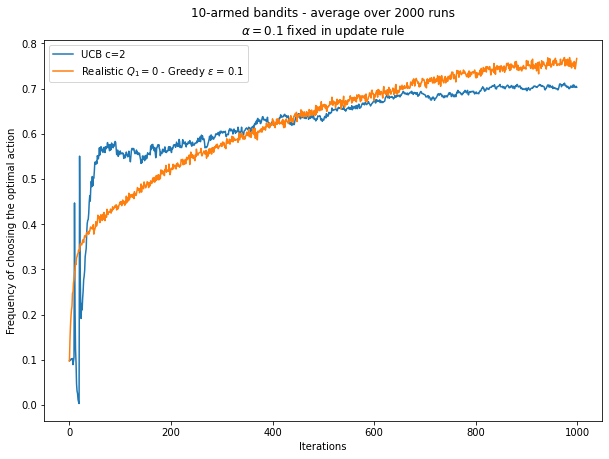

In [35]:
plt.figure(figsize=(10, 7))
plt.plot(freq_optimal_actions_ucb, label=r'UCB c=2')
plt.plot(freq_optimal_actions_init_0_eps_01, label=r'Realistic $Q_1=0$ - Greedy $\epsilon$ = 0.1')
plt.title("10-armed bandits - average over 2000 runs\n" + r"$\alpha=0.1$ fixed in update rule")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

__Comment varie la courbe de performance selon la valeur du paramètre c de UCB?__

In [39]:
c_list = [-5, 0.5, 1, 2, 5, 10]
rewards_avg_list = []
freq_optimal_actions_list = []
for c in c_list:
    agent = lambda: UCBAgent(c=c)
    _, rewards_avg, freq_optimal_actions = simulation(agent_class=agent)
    rewards_avg_list.append(rewards_avg)
    freq_optimal_actions_list.append(freq_optimal_actions)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 2000/2000 [00:54<00:00, 36.86it/s]


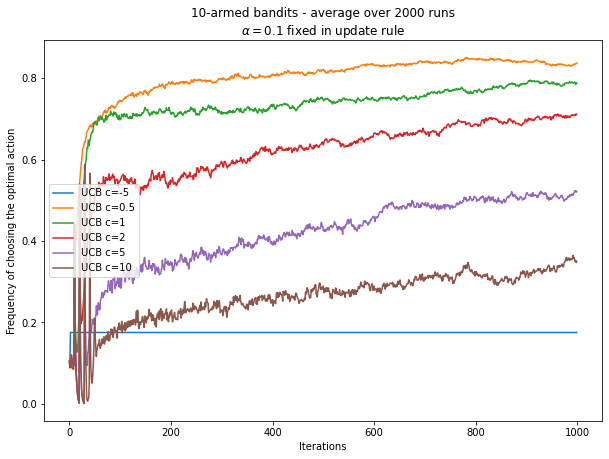

In [40]:
plt.figure(figsize=(10, 7))
for i, c in enumerate(c_list):
    plt.plot(freq_optimal_actions_list[i], label=f'UCB c={c}')
plt.title("10-armed bandits - average over 2000 runs\n" + r"$\alpha=0.1$ fixed in update rule")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

Plus $c$ tend vers 0, plus la courbe de performance est haute.

## <a name="sec4">4. Gradient Bandit<a/>

Jusqu'à présent, on apprend une estimation $Q$ de la fonction de valeur $q_*$, puis on utilise cette estimation pour choisir une action. Maintenant, on souhaite apprendre une fonction de préférences : plus on préfère une action, plus souvent on va la prendre. On note $H_t(a)$ la préférence pour l'action $a$ au pas de temps $t$. On associe à chaque action $a$ la distribution de Boltzmann :

$$
P(A_t = a) = \frac{e^{H_t(a)}}{\sum_{b=1}^{10} e^{H_t(b)}} = \pi_t(a)
$$

__Learn__

On utilise l'idée de la montée de gradient stochatique pour mettre à jour la fonction de préférence.

$$
H_{t+1}(a) = \begin{cases}H_t(a) + \alpha(R_t - \bar{R}_t)(1-\pi_t(a)) & \text{if} \space a = A_t \\
H_t(a) - \alpha(R_t - \bar{R}_t)\pi_t(a) & \text{otherwise} \end{cases}
$$

__Act__

Puis, on choisit l'action qui a la plus grande probabilité.

In [49]:
class GradientAgent():
    def __init__(self, n_machines=10, init=0, alpha=0.1):
        self.t = 0 # Number of iterations
        self.n_machines = n_machines # Total number of machines
        self.N = np.zeros(n_machines) # Step count for each machine
        self.Q = init * np.ones(n_machines) # Initialization of Q
        self.alpha = alpha
        self.actions = np.arange(self.n_machines) # Map indexes to actions
        self.H = np.zeros(n_machines) # Preference function
        self.mean_reward = 0 # Used to update the preference function

    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) / np.sum(np.exp(self.H - np.max(self.H)), axis=0)

    def learn(self, action, reward):
        self.t += 1
        self.N[action] += 1

        # Compute mean reward
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.t

        # Update preference action
        self.H[action] = self.H[action] + self.alpha * (reward - self.mean_reward) * (1 - self.prob_action[action])
        actions_not_taken = self.actions != action
        self.H[actions_not_taken] = self.H[actions_not_taken] - self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]
    
    def act(self):
        self.softmax() # Update probabilities
        action = np.random.choice(self.actions, p=self.prob_action) # Select highest preference action
        return action

In [46]:
rewards_grad, rewards_grad_avg, freq_optimal_actions_grad = simulation(agent_class=GradientAgent)

100%|██████████| 2000/2000 [03:13<00:00, 10.36it/s]


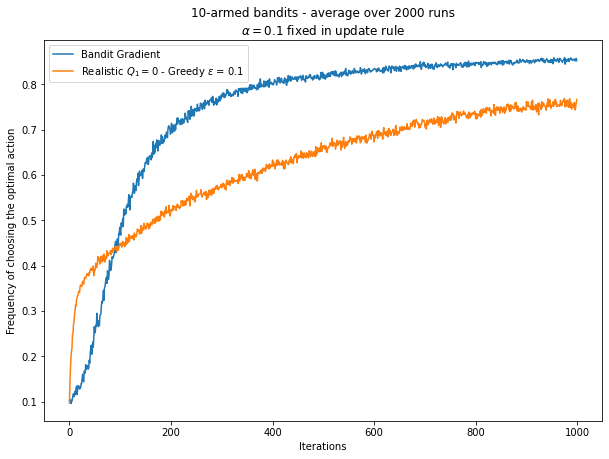

In [47]:
plt.figure(figsize=(10, 7))
plt.plot(freq_optimal_actions_grad, label=r'Bandit Gradient')
plt.plot(freq_optimal_actions_init_0_eps_01, label=r'Realistic $Q_1=0$ - Greedy $\epsilon$ = 0.1')
plt.title("10-armed bandits - average over 2000 runs\n" + r"$\alpha=0.1$ fixed in update rule")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

__Comment varie la courbe de performance selon la valeur du paramètre $\alpha$ pour la montée de gradient ?__

In [50]:
alpha_list = [0.1, 0.01, 0.001, 0.5, 1]
rewards_avg_list = []
freq_optimal_actions_list = []
for alpha in alpha_list:
    agent = lambda: GradientAgent(alpha=alpha)
    _, rewards_avg, freq_optimal_actions = simulation(agent_class=agent)
    rewards_avg_list.append(rewards_avg)
    freq_optimal_actions_list.append(freq_optimal_actions)

100%|██████████| 2000/2000 [02:57<00:00, 11.24it/s]


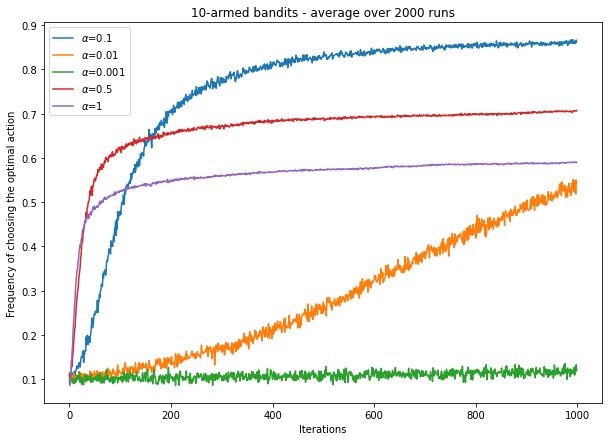

In [51]:
plt.figure(figsize=(10, 7))
for i, alpha in enumerate(alpha_list):
    plt.plot(freq_optimal_actions_list[i], label=r'$\alpha$={}'.format(alpha))
plt.title("10-armed bandits - average over 2000 runs")
plt.xlabel("Iterations")
plt.ylabel("Frequency of choosing the optimal action")
plt.legend()

Une valeur trop petite rend l'agent moins performant, e.g. $\alpha$=0.001 et avec un alpha qui tend vers 1, on plafonne à environ 55% de bons choix. $\alpha=0.1$ semble être le meilleur choix.